In [1]:
# import lib
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


In [2]:
train["color"].value_counts()

NameError: name 'train' is not defined

In [ ]:
# Enhanced Feature Engineering
def create_features(df):
    """Create additional features for better classification"""
    df = df.copy()
    
    # Encode color feature (previously excluded)
    le = LabelEncoder()
    df['color_encoded'] = le.fit_transform(df['color'])
    
    # Create interaction features
    df['bone_soul_ratio'] = df['bone_length'] / (df['has_soul'] + 0.001)
    df['flesh_hair_ratio'] = df['rotting_flesh'] / (df['hair_length'] + 0.001)
    
    # Create polynomial features
    df['bone_length_squared'] = df['bone_length'] ** 2
    df['has_soul_squared'] = df['has_soul'] ** 2
    
    # Create composite features
    df['total_physical'] = df['bone_length'] + df['rotting_flesh'] + df['hair_length']
    df['soul_physical_ratio'] = df['has_soul'] / (df['total_physical'] + 0.001)
    
    return df



In [ ]:

# Enhanced features (including color and engineered features)
feature_columns = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 
                   'color_encoded', 'bone_soul_ratio', 'flesh_hair_ratio',
                   'bone_length_squared', 'has_soul_squared', 'total_physical', 
                   'soul_physical_ratio']

X_enhanced = train_enhanced[feature_columns]
y = train_enhanced["type"]



In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multiple Models Comparison
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    # 'SVM': SVC(random_state=42, probability=True),
    # 'KNN': KNeighborsClassifier(n_neighbors=5),
    # 'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Evaluate all models
print("Model Comparison:")
print("=" * 50)
results = {}

for name, model in models.items():
    if name in ['SVM', 'KNN', 'Logistic Regression']:
        # Use scaled data for these models
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Use original data for tree-based models
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"  Test Accuracy: {accuracy:.3f}")
    print()

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Best Test Accuracy: {results[best_model_name]['test_accuracy']:.3f}")

# Hyperparameter Tuning for Best Model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
else:
    param_grid = {}

if param_grid:
    print(f"\nTuning {best_model_name} hyperparameters...")
    if best_model_name in ['SVM', 'KNN', 'Logistic Regression']:
        grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model_tuned = grid_search.best_estimator_
        y_pred_tuned = best_model_tuned.predict(X_test_scaled)
    else:
        grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model_tuned = grid_search.best_estimator_
        y_pred_tuned = best_model_tuned.predict(X_test)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Tuned accuracy: {accuracy_score(y_test, y_pred_tuned):.3f}")
    
    # Use tuned model for final results
    final_predictions = y_pred_tuned
    final_model = best_model_tuned
else:
    final_predictions = best_predictions
    final_model = best_model

# Final Results
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy_score(y_test, final_predictions):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ghost', 'Ghoul', 'Goblin'],
            yticklabels=['Ghost', 'Ghoul', 'Goblin'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance (for tree-based models)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()
    
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())

# Prepare submission
test_features = test_enhanced[feature_columns]
if best_model_name in ['SVM', 'KNN', 'Logistic Regression']:
    test_features_scaled = scaler.transform(test_features)
    test_predictions = final_model.predict(test_features_scaled)
else:
    test_predictions = final_model.predict(test_features)

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'type': test_predictions
})

submission.to_csv('enhanced_submission.csv', index=False)
print(f"\nSubmission file 'enhanced_submission.csv' created with {best_model_name} predictions.")

=== FEATURE ENGINEERING EXPLANATION ===

1. INTERACTION FEATURES:
------------------------------
bone_soul_ratio = bone_length / has_soul
This captures the balance between physical structure and spiritual essence.

Average bone_soul_ratio by monster type:
type
Ghost     1.867
Ghoul     0.903
Goblin    0.952
Name: bone_soul_ratio, dtype: float64

2. POLYNOMIAL FEATURES:
------------------------------
bone_length_squared = bone_length²
This captures non-linear relationships and amplifies extreme values.

Average bone_length_squared by monster type:
type
Ghost     0.134
Ghoul     0.282
Goblin    0.195
Name: bone_length_squared, dtype: float64

3. COMPOSITE FEATURES:
------------------------------
total_physical = bone_length + rotting_flesh + hair_length
This represents overall physical development.

Average total_physical by monster type:
type
Ghost     1.314
Ghoul     1.663
Goblin    1.417
Name: total_physical, dtype: float64

soul_physical_ratio = has_soul / total_physical
This measure

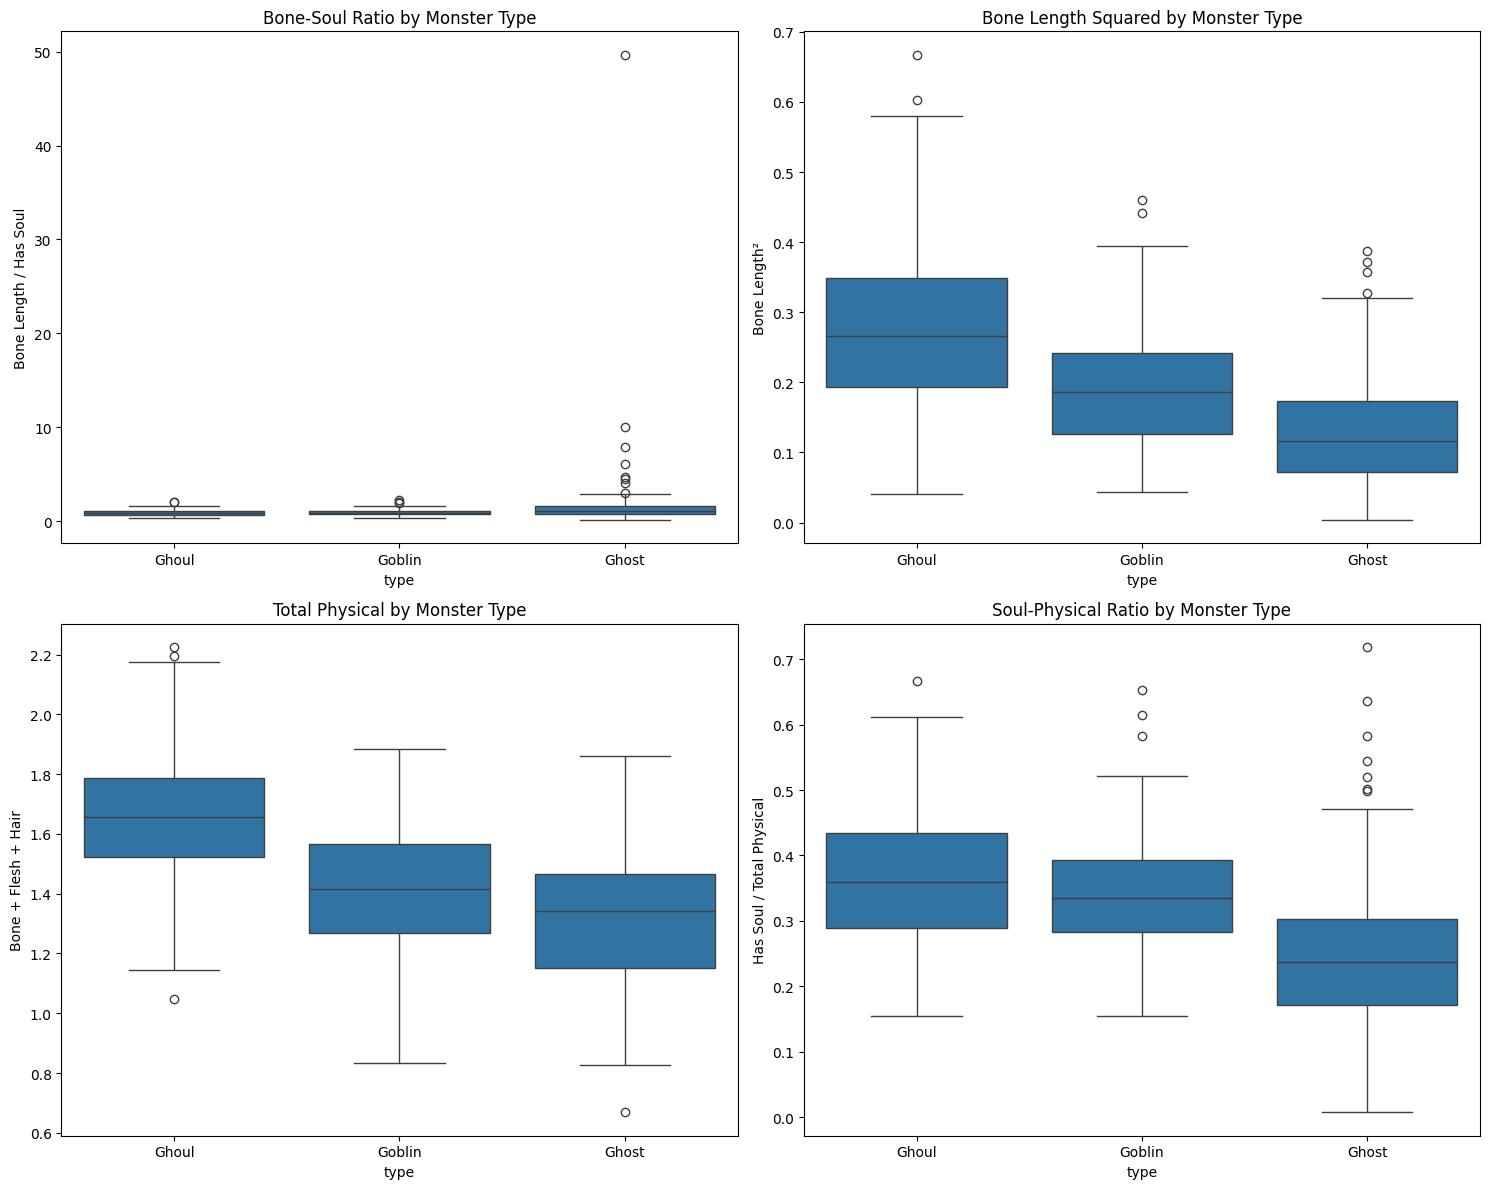


=== HOW THESE FEATURES HELP CLASSIFICATION ===

1. INTERACTION FEATURES help by:
   - Capturing relationships between features that simple features miss
   - Creating ratios that normalize for scale differences
   - Revealing balance/imbalance patterns

2. POLYNOMIAL FEATURES help by:
   - Capturing non-linear relationships
   - Amplifying differences in extreme values
   - Creating quadratic decision boundaries

3. COMPOSITE FEATURES help by:
   - Summarizing multiple related features into meaningful metrics
   - Creating domain-specific measurements (like 'spiritual balance')
   - Reducing dimensionality while preserving important information

=== EXAMPLE: WHY GOBLIN CLASSIFICATION IMPROVES ===

Original features might not clearly distinguish Goblins, but:
- bone_soul_ratio: Goblins might have a specific bone-to-soul balance
- soul_physical_ratio: Goblins might be more physical than spiritual
- physical_variance: Goblins might have more variable physical attributes
- total_physical:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the data
train = pd.read_csv("train.csv/train.csv")

def create_features(df):
    """Create additional features for better classification"""
    df = df.copy()
    
    # Encode color feature
    le = LabelEncoder()
    df['color_encoded'] = le.fit_transform(df['color'])
    
    # Interaction features
    df['bone_soul_ratio'] = df['bone_length'] / (df['has_soul'] + 0.001)
    df['flesh_hair_ratio'] = df['rotting_flesh'] / (df['hair_length'] + 0.001)
    
    # Polynomial features
    df['bone_length_squared'] = df['bone_length'] ** 2
    df['has_soul_squared'] = df['has_soul'] ** 2
    
    # Composite features
    df['total_physical'] = df['bone_length'] + df['rotting_flesh'] + df['hair_length']
    df['soul_physical_ratio'] = df['has_soul'] / (df['total_physical'] + 0.001)
    df['physical_variance'] = df[['bone_length', 'rotting_flesh', 'hair_length']].var(axis=1)
    df['soul_physical_diff'] = df['has_soul'] - df['total_physical']/3
    
    return df

# Apply feature engineering
train_enhanced = create_features(train)

print("=== FEATURE ENGINEERING EXPLANATION ===\n")

print("1. INTERACTION FEATURES:")
print("-" * 30)
print("bone_soul_ratio = bone_length / has_soul")
print("This captures the balance between physical structure and spiritual essence.")
print("\nAverage bone_soul_ratio by monster type:")
print(train_enhanced.groupby('type')['bone_soul_ratio'].mean().round(3))

print("\n2. POLYNOMIAL FEATURES:")
print("-" * 30)
print("bone_length_squared = bone_length²")
print("This captures non-linear relationships and amplifies extreme values.")
print("\nAverage bone_length_squared by monster type:")
print(train_enhanced.groupby('type')['bone_length_squared'].mean().round(3))

print("\n3. COMPOSITE FEATURES:")
print("-" * 30)
print("total_physical = bone_length + rotting_flesh + hair_length")
print("This represents overall physical development.")
print("\nAverage total_physical by monster type:")
print(train_enhanced.groupby('type')['total_physical'].mean().round(3))

print("\nsoul_physical_ratio = has_soul / total_physical")
print("This measures spiritual vs. physical balance.")
print("\nAverage soul_physical_ratio by monster type:")
print(train_enhanced.groupby('type')['soul_physical_ratio'].mean().round(3))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Interaction feature
sns.boxplot(data=train_enhanced, x='type', y='bone_soul_ratio', ax=axes[0,0])
axes[0,0].set_title('Bone-Soul Ratio by Monster Type')
axes[0,0].set_ylabel('Bone Length / Has Soul')

# Polynomial feature
sns.boxplot(data=train_enhanced, x='type', y='bone_length_squared', ax=axes[0,1])
axes[0,1].set_title('Bone Length Squared by Monster Type')
axes[0,1].set_ylabel('Bone Length²')

# Composite feature 1
sns.boxplot(data=train_enhanced, x='type', y='total_physical', ax=axes[1,0])
axes[1,0].set_title('Total Physical by Monster Type')
axes[1,0].set_ylabel('Bone + Flesh + Hair')

# Composite feature 2
sns.boxplot(data=train_enhanced, x='type', y='soul_physical_ratio', ax=axes[1,1])
axes[1,1].set_title('Soul-Physical Ratio by Monster Type')
axes[1,1].set_ylabel('Has Soul / Total Physical')

plt.tight_layout()
plt.show()

print("\n=== HOW THESE FEATURES HELP CLASSIFICATION ===")
print("\n1. INTERACTION FEATURES help by:")
print("   - Capturing relationships between features that simple features miss")
print("   - Creating ratios that normalize for scale differences")
print("   - Revealing balance/imbalance patterns")

print("\n2. POLYNOMIAL FEATURES help by:")
print("   - Capturing non-linear relationships")
print("   - Amplifying differences in extreme values")
print("   - Creating quadratic decision boundaries")

print("\n3. COMPOSITE FEATURES help by:")
print("   - Summarizing multiple related features into meaningful metrics")
print("   - Creating domain-specific measurements (like 'spiritual balance')")
print("   - Reducing dimensionality while preserving important information")

print("\n=== EXAMPLE: WHY GOBLIN CLASSIFICATION IMPROVES ===")
print("\nOriginal features might not clearly distinguish Goblins, but:")
print("- bone_soul_ratio: Goblins might have a specific bone-to-soul balance")
print("- soul_physical_ratio: Goblins might be more physical than spiritual")
print("- physical_variance: Goblins might have more variable physical attributes")
print("- total_physical: Goblins might have a characteristic total physical score")